# EDS Case Study

Explore changes in political views

Allen Downey

[MIT License](https://en.wikipedia.org/wiki/MIT_License)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from utils import decorate

## Loading and validation


In [2]:
gss = pd.read_hdf('eds.gss.hdf5', 'gss')
gss.shape

(64814, 105)

### Validating `polviews`

`polviews` contains responses to the [following question](https://gssdataexplorer.norc.org/projects/52787/variables/178/vshow)

> We hear a lot of talk these days about liberals and conservatives. 
I'm going to show you a seven-point scale on which the political views that people might hold are arranged from extremely liberal--point 1--to extremely conservative--point 7. Where would you place yourself on this scale?

`values` takes a variable column and returns a series of values and their frequencies.

In [3]:
def values(series):
    return series.value_counts().sort_index()

In [4]:
values(gss['polviews'])

1.0     1637
2.0     6398
3.0     6865
4.0    21521
5.0     8953
6.0     8149
7.0     1833
Name: polviews, dtype: int64

In [5]:
gss74 = gss['year']==1974
gss74.sum()

1484

In [6]:
polviews74 = gss.loc[gss74, 'polviews']
values(polviews74)

1.0     21
2.0    191
3.0    201
4.0    543
5.0    252
6.0    169
7.0     34
Name: polviews, dtype: int64

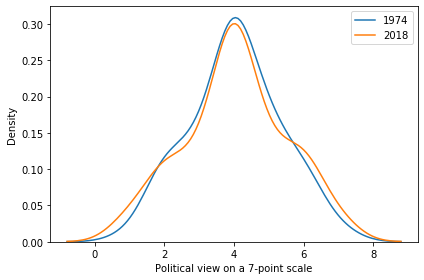

In [7]:
gss18 = gss['year'] == 2018
polviews18 = gss.loc[gss18, 'polviews']

sns.kdeplot(polviews74.dropna(), bw=0.6, label='1974')
sns.kdeplot(polviews18.dropna(), bw=0.6, label='2018')

decorate(xlabel='Political view on a 7-point scale',
         ylabel='Density')

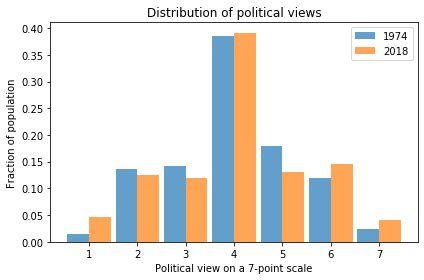

In [8]:
from empiricaldist import Pmf

Pmf.from_seq(polviews74).bar(label='1974', width=-0.45, align='edge', alpha=0.7)
Pmf.from_seq(polviews18).bar(label='2018', width=0.45, align='edge', alpha=0.7)

decorate(xlabel='Political view on a 7-point scale',
         ylabel='Fraction of population',
         title='Distribution of political views')

In [9]:
polviews74 = gss.loc[gss74, 'polviews']
values(polviews74)

1.0     21
2.0    191
3.0    201
4.0    543
5.0    252
6.0    169
7.0     34
Name: polviews, dtype: int64

In [10]:
polviews74 = gss.loc[gss74, 'polviews']
values(polviews74)

1.0     21
2.0    191
3.0    201
4.0    543
5.0    252
6.0    169
7.0     34
Name: polviews, dtype: int64

In [11]:
by_year = gss.groupby('year')
by_year

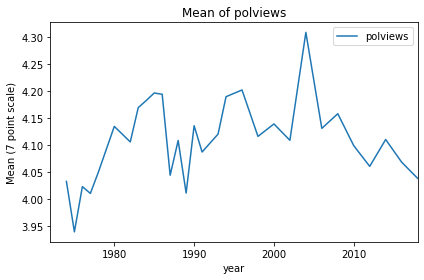

In [12]:
series = by_year['polviews'].mean()
series.plot(label='polviews')
decorate(ylabel='Mean (7 point scale)',
         title='Mean of polviews')

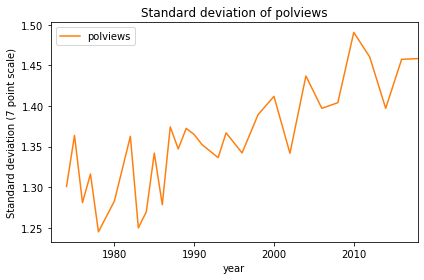

In [13]:
series = by_year['polviews'].std()
series.plot(color='C1', label='polviews')
decorate(ylabel='Standard deviation (7 point scale)',
         title='Standard deviation of polviews')

### Local regression

In [14]:
from statsmodels.nonparametric.smoothers_lowess import lowess

def make_lowess(series):
    endog = series.values
    exog = series.index.values

    smooth = lowess(endog, exog)
    index, data = np.transpose(smooth)

    return pd.Series(data, index=index) 

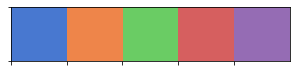

In [15]:
palette = sns.color_palette('muted', 5)
sns.palplot(palette)

In [16]:
colors = dict(Conservative=palette[3], 
              Moderate=palette[4], 
              Liberal=palette[0])

In [17]:
def plot_series_lowess(series, color):
    series.plot(lw=0, marker='o', color=color, alpha=0.5)
    smooth = make_lowess(series)
    smooth.plot(label='_', color=color)

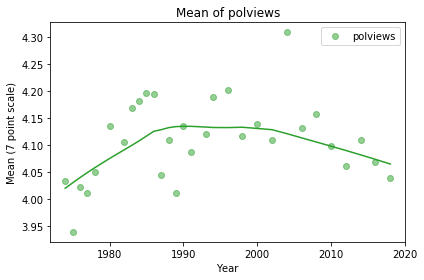

In [18]:
series = by_year['polviews'].mean()
plot_series_lowess(series, 'C2')
decorate(ylabel='Mean (7 point scale)',
         title='Mean of polviews',
         xlabel='Year',
         xlim=[1972, 2020])

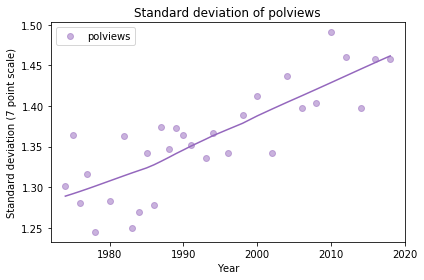

In [19]:
series = by_year['polviews'].std()
plot_series_lowess(series, color='C4')
decorate(ylabel='Standard deviation (7 point scale)',
         title='Standard deviation of polviews',
         xlabel='Year',
         xlim=[1972, 2020])

### Categorical data

In [20]:
# recode the 7 point scale with words
d = {1:'Extremely liberal', 
     2:'Liberal', 
     3:'Slightly liberal', 
     4:'Moderate', 
     5:'Slightly conservative', 
     6:'Conservative', 
     7:'Extremely conservative'}

gss['polviews7'] = gss.polviews.replace(d)
values(gss['polviews7'])

Conservative               8149
Extremely conservative     1833
Extremely liberal          1637
Liberal                    6398
Moderate                  21521
Slightly conservative      8953
Slightly liberal           6865
Name: polviews7, dtype: int64

In [21]:
def count_by_year(gss, varname):
    """Groups by category and year and counts.
    
    gss: DataFrame
    varname: string variable to group by
    
    returns: DataFrame with one row per year, one column per category.
    """
    grouped = gss.groupby([varname, 'year'])
    count = grouped[varname].count().unstack(level=0)
    
    # note: the following is not ideal, because it does not
    # distinguish 0 from NA
    count = count.replace(0, np.nan).dropna()
    return count

In [22]:
polviews7_count = count_by_year(gss, 'polviews7')
polviews7_count.head()

polviews7,Conservative,Extremely conservative,Extremely liberal,Liberal,Moderate,Slightly conservative,Slightly liberal
year,,,,,,,
1974,169,34,21,191,543,252,201
1975,158,34,65,169,565,220,190
1976,170,24,32,169,571,242,188
1977,176,36,35,181,579,232,210
1978,165,26,30,144,584,263,222


In [23]:
def normalize_by_year(df):
    """Divide each row by its total.
    
    df: DataFrame with one year per row, one category per column
    """
    # add up the elements of each row
    total = df.sum(axis=1)
    
    # divide each column by the total
    return df.div(total, axis=0)

In [24]:
polviews7_norm = normalize_by_year(polviews7_count)
polviews7_norm.head()

polviews7,Conservative,Extremely conservative,Extremely liberal,Liberal,Moderate,Slightly conservative,Slightly liberal
year,,,,,,,
1974,0.119773,0.024096,0.014883,0.135365,0.384833,0.178597,0.142452
1975,0.112777,0.024268,0.046395,0.120628,0.403283,0.157031,0.135617
1976,0.121777,0.017192,0.022923,0.121060,0.409026,0.173352,0.134670
1977,0.121463,0.024845,0.024155,0.124914,0.399586,0.160110,0.144928
1978,0.115063,0.018131,0.020921,0.100418,0.407252,0.183403,0.154812


In [25]:
def plot_columns_lowess(df, columns, colors):
    """
    """
    for col in columns:
        series = df[col]
        plot_series_lowess(series, colors[col])

In [26]:
columns = d.values()
columns

dict_values(['Extremely liberal', 'Liberal', 'Slightly liberal', 'Moderate', 'Slightly conservative', 'Conservative', 'Extremely conservative'])

In [27]:
muted = sns.color_palette('muted', 5)
purple = muted[4]

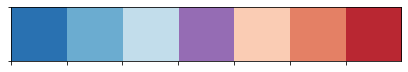

In [28]:
palette = sns.color_palette('RdBu_r', 7)
palette[3] = purple
sns.palplot(palette)

In [29]:
colors = dict(zip(columns, palette))

In [30]:
def anchor_legend(x, y):
    plt.legend(bbox_to_anchor=(x, y), loc='upper left', ncol=1)

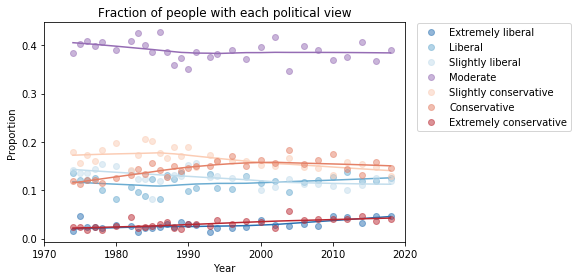

In [31]:
plot_columns_lowess(polviews7_norm, columns, colors)
decorate(xlabel='Year',
         ylabel='Proportion',
         title='Fraction of people with each political view',
         xlim=[1970, 2020])

anchor_legend(1.02, 1.02)

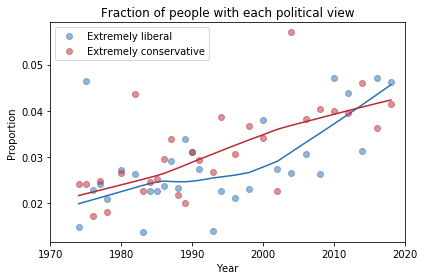

In [32]:
columns2 = ['Extremely liberal', 'Extremely conservative']

plot_columns_lowess(polviews7_norm, columns2, colors)
decorate(xlabel='Year',
         ylabel='Proportion',
         title='Fraction of people with each political view',
         xlim=[1970, 2020])

### 3-point scale

To make it easier to visualize groups, I'm going to lump the 7-point scale into a 3-point scale.

With this scale, there are roughly the same number of people in each group.

In [33]:
# replace 7 point scale with 3 point scale
d = {1:'Liberal (all)', 
     2:'Liberal (all)', 
     3:'Liberal (all)', 
     4:'Moderate', 
     5:'Conservative (all)', 
     6:'Conservative (all)', 
     7:'Conservative (all)'}

gss['polviews3'] = gss.polviews.replace(d)
values(gss['polviews3'])

Conservative (all)    18935
Liberal (all)         14900
Moderate              21521
Name: polviews3, dtype: int64

In [34]:
polviews3_count = count_by_year(gss, 'polviews3')
polviews3_count.head()

polviews3,Conservative (all),Liberal (all),Moderate
year,,,
1974,455,413,543
1975,412,424,565
1976,436,389,571
1977,444,426,579
1978,454,396,584


In [35]:
polviews3_norm = normalize_by_year(polviews3_count)
polviews3_norm.head()

polviews3,Conservative (all),Liberal (all),Moderate
year,,,
1974,0.322466,0.292700,0.384833
1975,0.294076,0.302641,0.403283
1976,0.312321,0.278653,0.409026
1977,0.306418,0.293996,0.399586
1978,0.316597,0.276151,0.407252


In [36]:
polviews3_norm.tail()

polviews3,Conservative (all),Liberal (all),Moderate
year,,,
2010,0.347021,0.282424,0.370556
2012,0.342063,0.281133,0.376804
2014,0.331296,0.262021,0.406683
2016,0.341428,0.291410,0.367162
2018,0.318040,0.290869,0.391091


In [37]:
colors = {'Conservative (all)':muted[3], 
          'Moderate':muted[4], 
          'Liberal (all)':muted[0]}

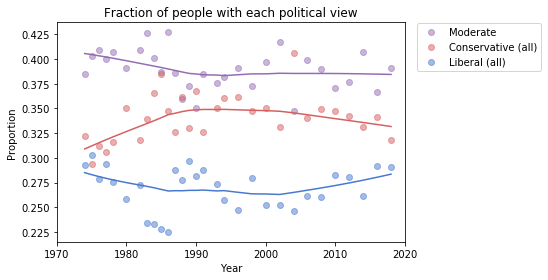

In [38]:
columns = ['Moderate', 'Conservative (all)', 'Liberal (all)']
plot_columns_lowess(polviews3_norm, columns, colors)
decorate(xlabel='Year',
         ylabel='Proportion',
         title='Fraction of people with each political view',
         xlim=[1970, 2020])

anchor_legend(1.02, 1.02)